# Simple Contextual Bandit DGP Example

This notebook demonstrates how to use the Simple contextual bandit data generating process with Bernoulli random assignment and regret calculation.

In [1]:
import numpy as np
import pandas as pd
from plotnine import *
from demo.contextual_bandit_dgp import Simple

## 1. Initialize the DGP

Create a Simple contextual bandit DGP with:
- 3 arms
- 5 context features
- Shared weight of 0.3 (30% shared, 70% arm-specific)

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Initialize the DGP
n_arms = 3
n_features = 5
shared_weight = 0.3

dgp = Simple(n_arms=n_arms, n_features=n_features, shared_weight=shared_weight)

print(f"Beta coefficients shape: {dgp.beta.shape}")
print(f"\nBeta coefficients:\n{dgp.beta}")

Beta coefficients shape: (3, 6)

Beta coefficients:
[[ 1.25446322  0.49572502 -0.13432551  0.83670099 -0.3946384  -0.39625191]
 [ 0.31838784 -1.38077546 -1.01313592  0.06330769 -0.7792278   0.14973205]
 [-0.48660261 -1.03009188  1.2202607   0.29886555 -0.02297627 -1.06756482]]


## 2. Generate Contexts and Simulate Random Assignment

Generate contexts and simulate a Bernoulli random assignment strategy where each arm is chosen with equal probability.

In [3]:
# Number of samples
n_samples = 1000

# Generate contexts (n_samples, n_features)
contexts = np.random.normal(size=(n_samples, n_features))

# Bernoulli random assignment: choose arms uniformly at random
assigned_arms = np.random.randint(0, n_arms, size=n_samples)

print(f"Generated {n_samples} contexts with shape: {contexts.shape}")
print(f"Assigned arms shape: {assigned_arms.shape}")
print(f"\nArm assignment distribution:")
for arm in range(n_arms):
    count = np.sum(assigned_arms == arm)
    print(f"  Arm {arm}: {count} ({count/n_samples*100:.1f}%)")

Generated 1000 contexts with shape: (1000, 5)
Assigned arms shape: (1000,)

Arm assignment distribution:
  Arm 0: 341 (34.1%)
  Arm 1: 343 (34.3%)
  Arm 2: 316 (31.6%)


## 3. Compute Rewards and Optimal Actions

Compute:
- Observed rewards from the assigned arms
- Optimal arms for each context
- Optimal rewards

In [4]:
# Compute observed rewards for assigned arms
observed_rewards = dgp.r(assigned_arms, contexts)

# Compute optimal arms and rewards
optimal_arms = dgp.a_star(contexts)
optimal_rewards = dgp.r_star(contexts)

print(f"Observed rewards shape: {observed_rewards.shape}")
print(f"Optimal arms shape: {optimal_arms.shape}")
print(f"Optimal rewards shape: {optimal_rewards.shape}")
print(f"\nMean observed reward: {observed_rewards.mean():.3f}")
print(f"Mean optimal reward: {optimal_rewards.mean():.3f}")

Observed rewards shape: (1000,)
Optimal arms shape: (1000,)
Optimal rewards shape: (1000,)

Mean observed reward: 0.314
Mean optimal reward: 1.928


## 4. Calculate Regret

Regret is the difference between the optimal reward and the observed reward.

In [5]:
# Calculate instantaneous regret
instantaneous_regret = optimal_rewards - observed_rewards

# Calculate cumulative regret
cumulative_regret = np.cumsum(instantaneous_regret)

print(f"Mean instantaneous regret: {instantaneous_regret.mean():.3f}")
print(f"Total cumulative regret: {cumulative_regret[-1]:.3f}")
print(f"\nRegret statistics:")
print(f"  Min: {instantaneous_regret.min():.3f}")
print(f"  Max: {instantaneous_regret.max():.3f}")
print(f"  Std: {instantaneous_regret.std():.3f}")

Mean instantaneous regret: 1.614
Total cumulative regret: 1613.753

Regret statistics:
  Min: -0.000
  Max: 9.305
  Std: 1.813


## 5. Analyze Optimal Arm Selection

Check how often random assignment matched the optimal arm.

In [6]:
# Check how often we selected the optimal arm
optimal_selections = assigned_arms == optimal_arms
optimal_selection_rate = optimal_selections.mean()

print(f"Optimal arm selection rate: {optimal_selection_rate*100:.2f}%")
print(f"Expected rate (random): {1/n_arms*100:.2f}%")

print(f"\nOptimal arm distribution:")
for arm in range(n_arms):
    count = np.sum(optimal_arms == arm)
    print(f"  Arm {arm}: {count} ({count/n_samples*100:.1f}%)")

Optimal arm selection rate: 32.50%
Expected rate (random): 33.33%

Optimal arm distribution:
  Arm 0: 567 (56.7%)
  Arm 1: 278 (27.8%)
  Arm 2: 155 (15.5%)


## 6. Visualize Results

In [7]:
# Create a dataframe for plotting
df_regret = pd.DataFrame({
    'sample': np.arange(n_samples),
    'cumulative_regret': cumulative_regret,
    'instantaneous_regret': instantaneous_regret
})

df_rewards = pd.DataFrame({
    'optimal_reward': optimal_rewards,
    'observed_reward': observed_rewards
})

df_arms = pd.DataFrame({
    'arm': list(range(n_arms)) * 2,
    'count': [np.sum(assigned_arms == i) for i in range(n_arms)] + 
             [np.sum(optimal_arms == i) for i in range(n_arms)],
    'type': ['Assigned'] * n_arms + ['Optimal'] * n_arms
})

# Plot 1: Cumulative Regret
p1 = (ggplot(df_regret, aes(x='sample', y='cumulative_regret')) +
      geom_line(size=1) +
      labs(title='Cumulative Regret over Time',
           x='Sample',
           y='Cumulative Regret') +
      theme_minimal())

# Plot 2: Instantaneous Regret Histogram
mean_regret = instantaneous_regret.mean()
p2 = (ggplot(df_regret, aes(x='instantaneous_regret')) +
      geom_histogram(bins=50, fill='steelblue', color='black', alpha=0.7) +
      geom_vline(xintercept=mean_regret, color='red', linetype='dashed', size=1) +
      annotate('text', x=mean_regret, y=40, 
               label=f'Mean: {mean_regret:.3f}', 
               color='red', ha='left', size=10) +
      labs(title='Distribution of Instantaneous Regret',
           x='Instantaneous Regret',
           y='Frequency') +
      theme_minimal())

# Plot 3: Observed vs Optimal Rewards
p3 = (ggplot(df_rewards, aes(x='optimal_reward', y='observed_reward')) +
      geom_point(alpha=0.3, size=1.5) +
      geom_abline(intercept=0, slope=1, color='red', linetype='dashed', size=1) +
      annotate('text', x=df_rewards['optimal_reward'].max(), 
               y=df_rewards['optimal_reward'].max(),
               label='y=x (perfect assignment)', 
               color='red', ha='right', size=10) +
      labs(title='Observed vs Optimal Rewards',
           x='Optimal Reward',
           y='Observed Reward') +
      theme_minimal())

# Plot 4: Arm Selection Comparison
df_arms['arm'] = df_arms['arm'].astype(str)
p4 = (ggplot(df_arms, aes(x='arm', y='count', fill='type')) +
      geom_bar(stat='identity', position='dodge', alpha=0.8) +
      labs(title='Assigned vs Optimal Arm Distribution',
           x='Arm',
           y='Count',
           fill='Type') +
      theme_minimal())

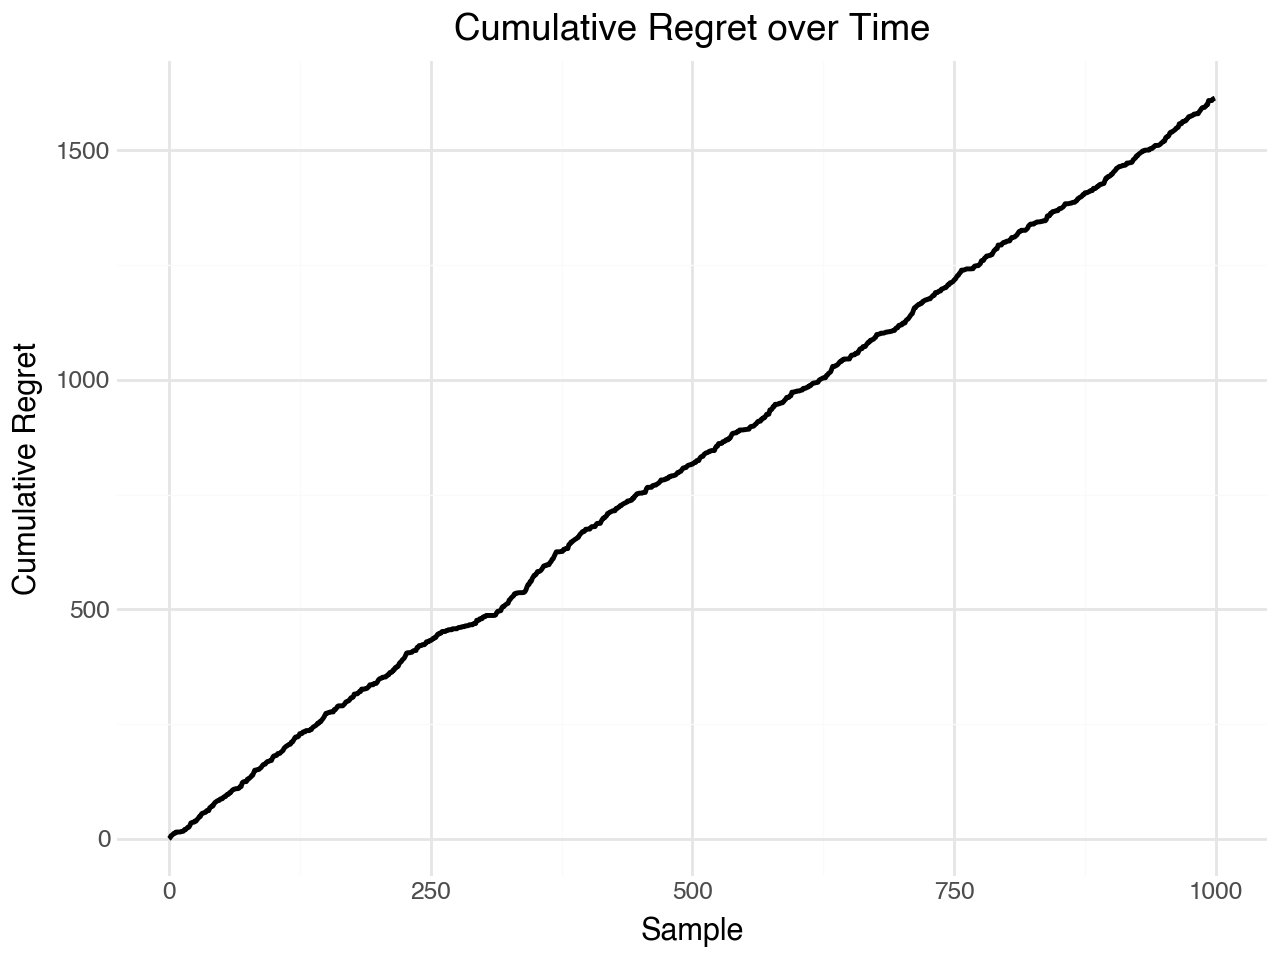

In [9]:
p1

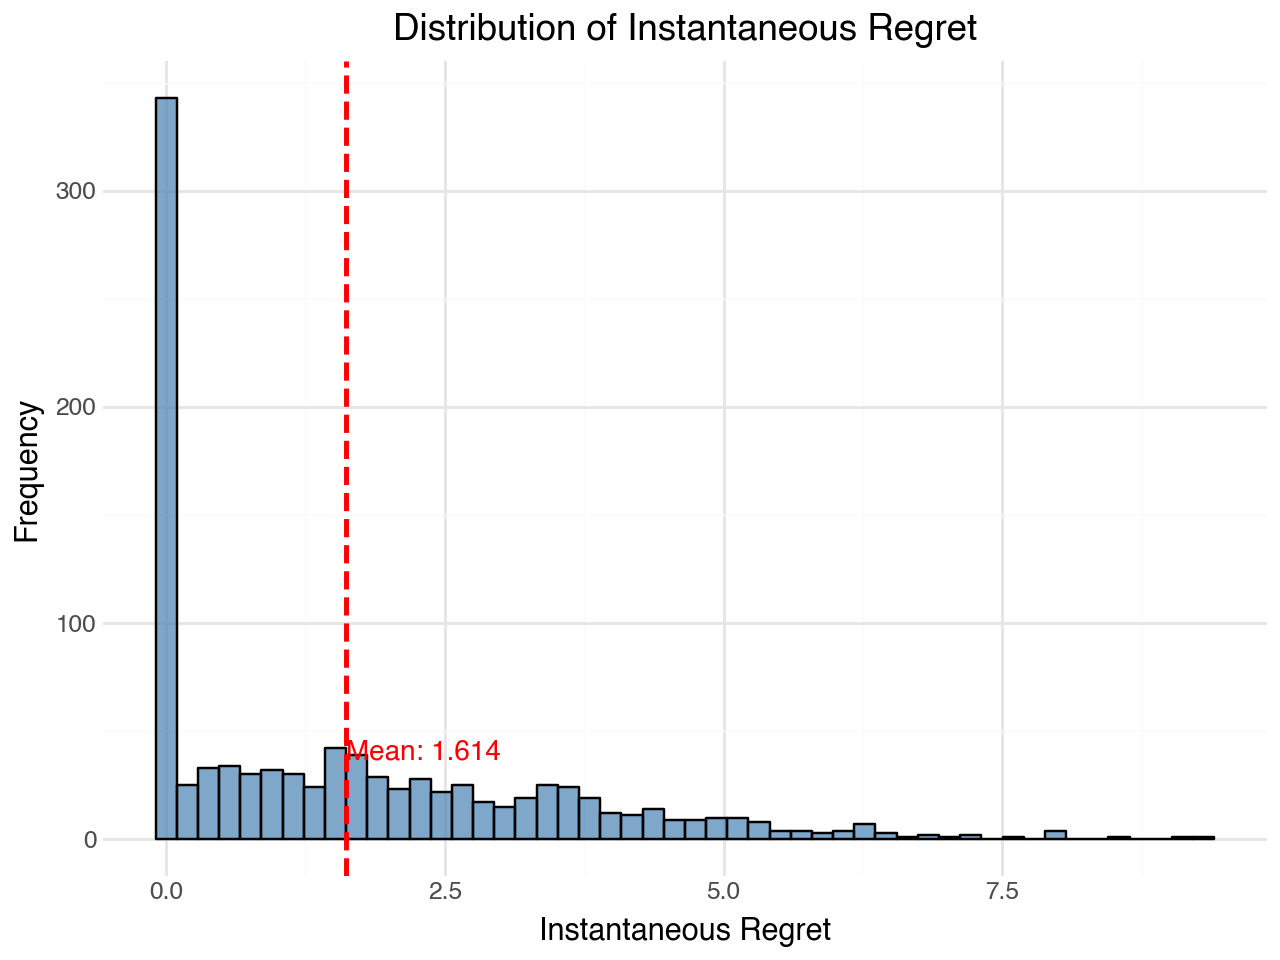

In [10]:
p2

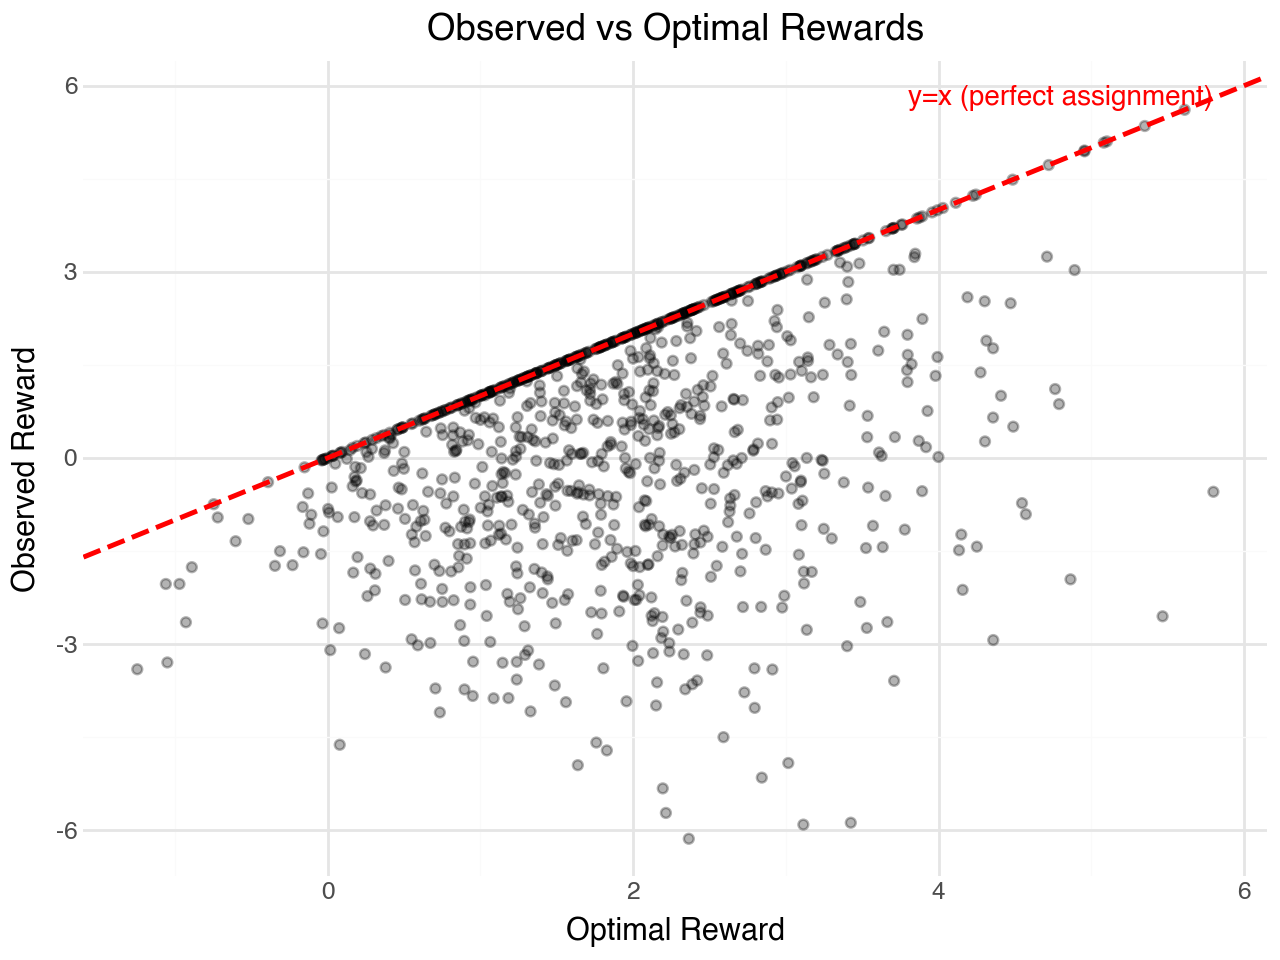

In [11]:
p3

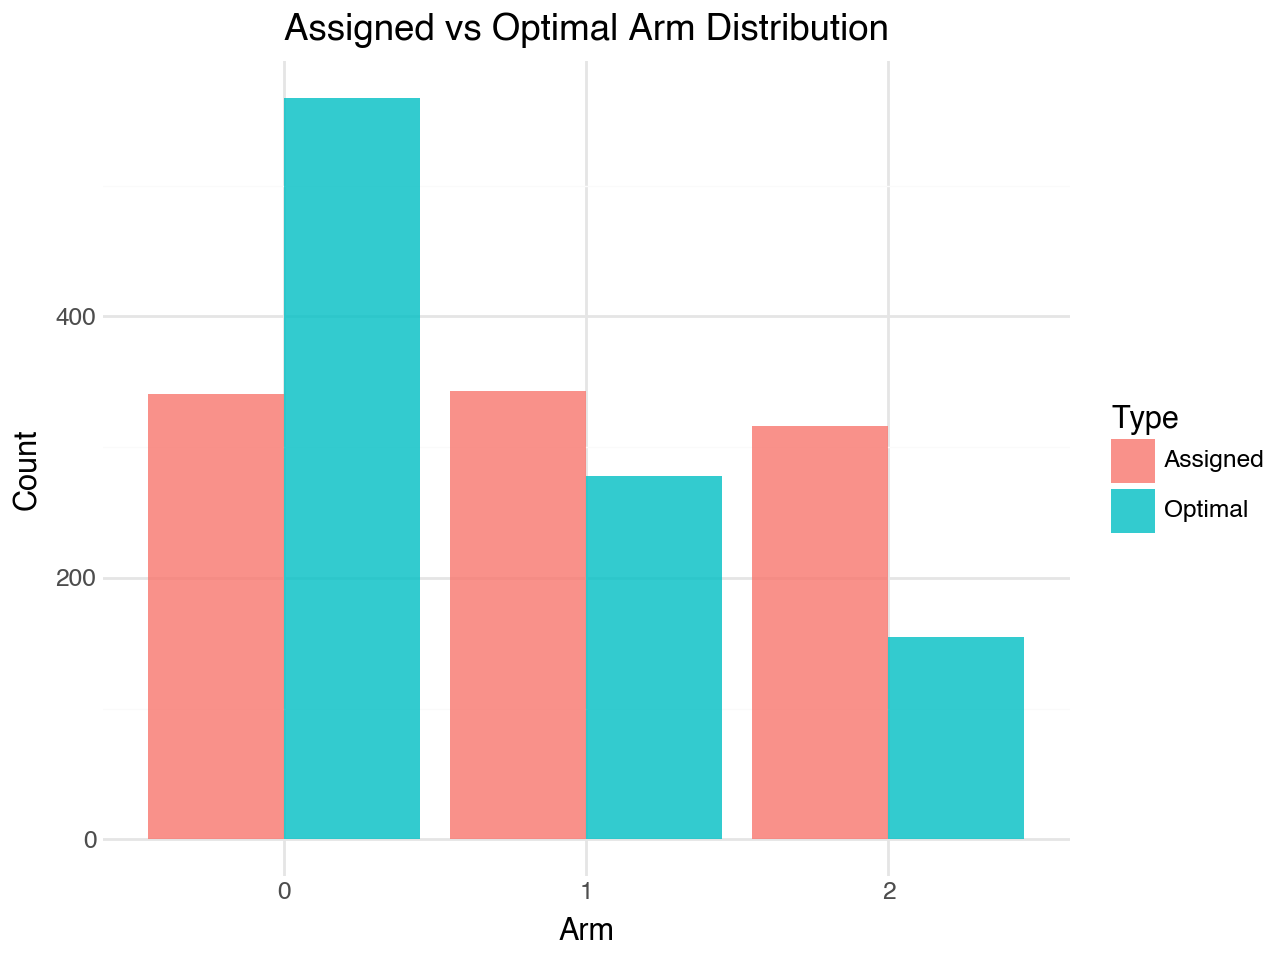

In [12]:
p4

## 7. Summary Statistics

In [8]:
print("="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"\nDGP Configuration:")
print(f"  Number of arms: {n_arms}")
print(f"  Number of features: {n_features}")
print(f"  Shared weight: {shared_weight}")
print(f"  Number of samples: {n_samples}")

print(f"\nPerformance Metrics:")
print(f"  Mean observed reward: {observed_rewards.mean():.4f}")
print(f"  Mean optimal reward: {optimal_rewards.mean():.4f}")
print(f"  Mean instantaneous regret: {instantaneous_regret.mean():.4f}")
print(f"  Total cumulative regret: {cumulative_regret[-1]:.4f}")
print(f"  Optimal arm selection rate: {optimal_selection_rate*100:.2f}%")
print(f"  Expected random selection rate: {1/n_arms*100:.2f}%")

print(f"\nRegret Analysis:")
print(f"  Regret std dev: {instantaneous_regret.std():.4f}")
print(f"  Min regret: {instantaneous_regret.min():.4f}")
print(f"  Max regret: {instantaneous_regret.max():.4f}")
print(f"  Median regret: {np.median(instantaneous_regret):.4f}")
print("="*60)

SUMMARY STATISTICS

DGP Configuration:
  Number of arms: 3
  Number of features: 5
  Shared weight: 0.3
  Number of samples: 1000

Performance Metrics:
  Mean observed reward: 0.3139
  Mean optimal reward: 1.9276
  Mean instantaneous regret: 1.6138
  Total cumulative regret: 1613.7529
  Optimal arm selection rate: 32.50%
  Expected random selection rate: 33.33%

Regret Analysis:
  Regret std dev: 1.8125
  Min regret: -0.0000
  Max regret: 9.3054
  Median regret: 1.0578
